# Plot IV and FI curves

Copyright (c) 2025 Open Brain Institute

Authors: Ilkan Kilic and Darshan Mandge

last modified: 01.2025

## Summary
This notebook demonstrates how to compute and plot the IV (current-voltage) and FI (frequency-current) curves for single cell model using BlueCelluLab. These analyses provide insights into the neuron’s electrical properties, such as its input resistance, firing threshold, and response to varying levels of stimulation. The notebook also explains how to set different injection and recording locations to study various neuron behaviors, like dendritic integration, backpropagation, and somatic excitability, through IV and FI curve analyses.

## Get the data
We can get the data using the entitysdk package. It has a function dedicated to download a SimulatableNeuron (also called MEModel). It will download a hoc file, a morphology and mechanisms (ion channel models).

To download the files, execute the following cell, and click on the link to set up authentication with the platform. If the code does not work, you might have to update the memodel_id, since it can change after a new deployment of the database.

In [1]:
from obi_auth import get_token
from entitysdk.client import Client
from entitysdk.downloaders.memodel import download_memodel
from entitysdk.models import MEModel


memodel_id = "9d4f3e32-1672-4265-bd6a-79067b52cab6"

token = get_token(environment="staging", auth_mode="daf")
client = Client(environment="staging", token_manager=token)

memodel = client.get_entity(
    entity_type=MEModel,
    entity_id=memodel_id,
)
downloaded_memodel = download_memodel(
    client, memodel=memodel
)

hoc_file = downloaded_memodel.hoc_path
morph_file = downloaded_memodel.morphology_path
mechanisms_folder = downloaded_memodel.mechanisms_dir

Next you will have to compile the mechanisms.

In [3]:
!nrnivmodl mechanisms

# Alternatively 
# import os
# os.system(f"{venv_path}/bin/nrnivmodl mechanisms")

/Users/aurelien/venvs/venv-py312/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/aurelien/repos/obi_platform_analysis_notebooks/Cellular/emodels/plot_iv_fi_curve
Mod files: "mechanisms/mechanisms/CaDynamics_DC0.mod" "mechanisms/mechanisms/Ca_HVA2.mod" "mechanisms/mechanisms/Ca_LVAst.mod" "mechanisms/mechanisms/Ih.mod" "mechanisms/mechanisms/K_Pst.mod" "mechanisms/mechanisms/K_Tst.mod" "mechanisms/mechanisms/NaTg.mod" "mechanisms/mechanisms/Nap_Et2.mod" "mechanisms/mechanisms/SK_E2.mod" "mechanisms/mechanisms/SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


In [4]:
from pathlib import Path
import json

from bluecellulab.analysis.analysis import compute_plot_iv_curve, compute_plot_fi_curve
from bluecellulab.cell import Cell
from bluecellulab.circuit.circuit_access import EmodelProperties
from bluecellulab.tools import calculate_rheobase
from bluecellulab.simulation.neuron_globals import NeuronGlobals

--No graphics will be displayed.


Let's get the holding and threshold current from the data.

In [5]:
holding_current = memodel.calibration_result.holding_current if memodel.calibration_result else None
threshold_current = memodel.calibration_result.threshold_current if memodel.calibration_result else None

print(f"Threshold Current = {threshold_current} nA")
print(f"Holding Current = {holding_current} nA")

Threshold Current = 0.0 nA
Holding Current = 0.0 nA


If the holding current and the threshold current are not available, we will use default values of 0 for both for now, and compute the threshold current later on.

In [13]:
if holding_current is None:
    print("No holding current provided, will set it to 0.")
    holding_current = 0
compute_threshold = False
if threshold_current is None or threshold_current == 0:
    compute_threshold = True
    threshold_current = 0
emodel_properties = EmodelProperties(
    threshold_current=threshold_current,
    holding_current=holding_current,
)

This cell sets global neuronal parameters for the NEURON simulation. The temperature affects ion channel kinetics, and the initial membrane potential should match the model’s resting voltage. Adjust these values based on your HOC model.

In [14]:
neuron_globals = NeuronGlobals.get_instance()
neuron_globals.temperature = 34.0
neuron_globals.v_init = -80.0

We can now create our cell using BlueCelluLab:

In [15]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

Now that we have a cell, we can compute its threshold current if it was not provided in the metadata. First, we compute its RMP (resting membrane potential) and Rin (internal resistance) to get a maximum bound for threshold current, and use a bisection search algorithm. BlueCelluLab can handle all of that:

In [16]:
if compute_threshold:
    print("No threshold current provided, will attempt to compute it. This will take a few seconds...")
    emodel_properties.threshold_current = calculate_rheobase(cell)

No threshold current provided, will attempt to compute it. This will take a few seconds...


In [17]:
print(f"threshold current is {emodel_properties.threshold_current} nA.")
print(f"holding current is {emodel_properties.holding_current} nA.")

threshold current is 0.0663706953671132 nA.
holding current is 0.0 nA.


To compute and plot the IV and FI curves, we can simply call the two functions below, passing only the cell as an argument. This runs the simulation with default parameters. 

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


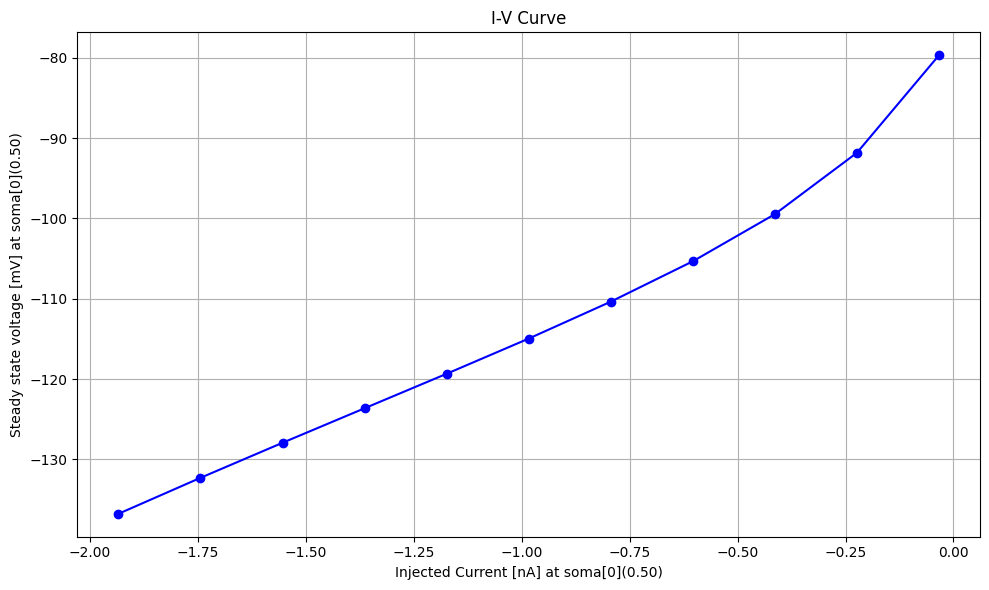

In [18]:
_, _ = compute_plot_iv_curve(cell)

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


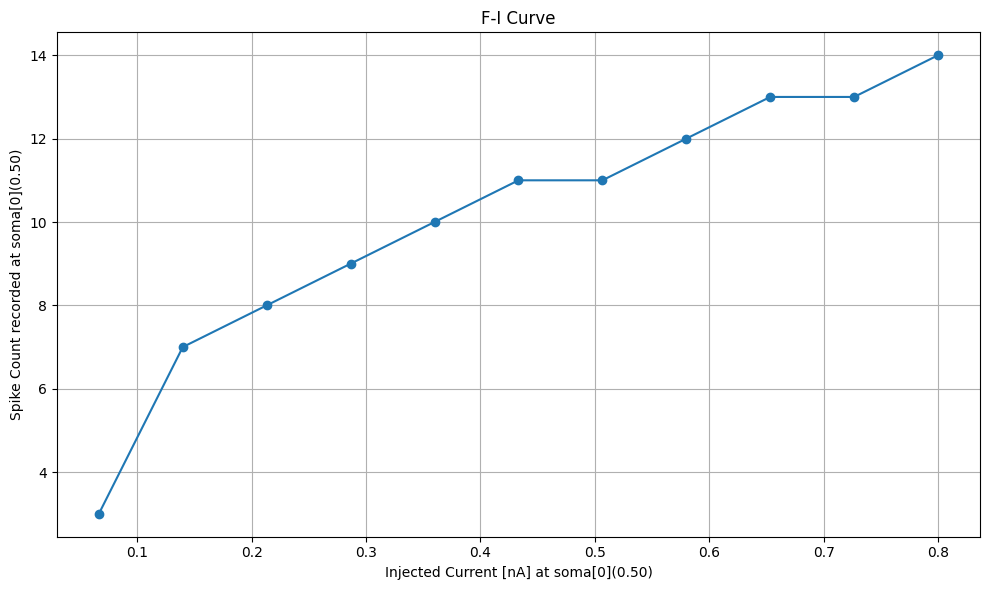

In [19]:
_, _ = compute_plot_fi_curve(cell)

By default, current injection and voltage recording occur at the soma. However, we can customize the simulation by adjusting parameters such as injection and recording locations, stimulus duration, voltage threshold, and more.

In [20]:
stim_start=100.0
duration=500.0
post_delay=100.0
threshold_voltage=-30
nb_bins = 11

## Use cases

The following cells present different use cases for computing and plotting IV and FI curves. Each case explores a unique injection and recording configuration to highlight key aspects of neuronal behavior, such as dendritic integration, backpropagation and axonal influence. These variations help demonstrate how different stimulation locations affect the cell's response.

In [21]:
def plot_iv_fi(injecting_section, injecting_segment, recording_section, recording_segment):
    _,_ = compute_plot_iv_curve(
        cell,
        injecting_section=injecting_section,
        injecting_segment=injecting_segment,
        recording_section=recording_section,
        recording_segment=recording_segment,
        stim_start=stim_start,
        duration=duration,
        post_delay=post_delay,
        threshold_voltage=threshold_voltage,
        nb_bins=nb_bins
    )
    _,_ = compute_plot_fi_curve(
        cell,
        injecting_section=injecting_section,
        injecting_segment=injecting_segment,
        recording_section=recording_section,
        recording_segment=recording_segment,
        stim_start=stim_start,
        duration=duration,
        post_delay=post_delay,
        nb_bins=nb_bins
    )

### Dendritic Integration and Attenuation

Injecting current at a dendrite and recording at the soma.
This setup shows how dendritic stimulation propagates to the soma, 
highlighting attenuation and possible active dendritic mechanisms.

In [22]:
injecting_section = "dend[50]"
injecting_segment = 0.5
recording_section = "soma[0]"
recording_segment = 0.5

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


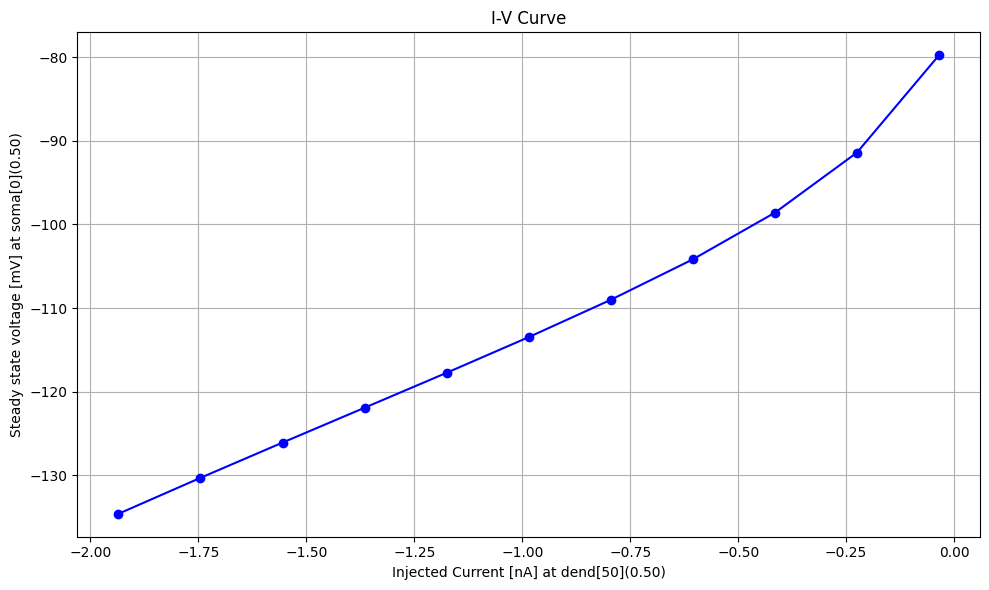

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


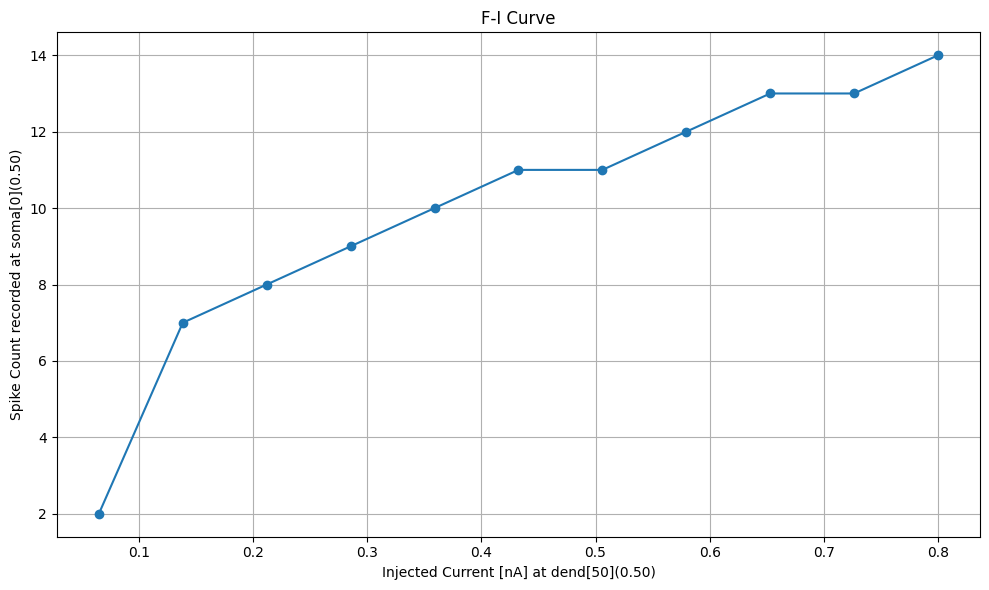

In [23]:
plot_iv_fi(injecting_section, injecting_segment, recording_section, recording_segment)

### Exploring Backpropagation from the Axon

Injecting current at the axon and recording at the soma.
This setup helps investigate whether axonal stimulation can backpropagate 
to the soma and affect firing properties.


In [24]:
injecting_section = "axon[0]"
injecting_segment = 0.5
recording_section = "soma[0]"
recording_segment = 0.5

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


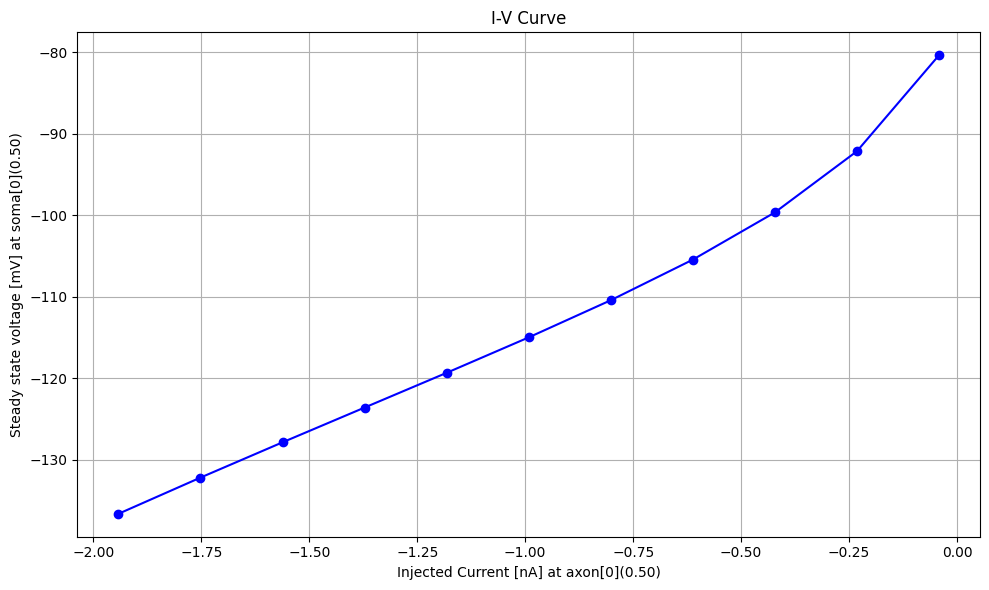

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


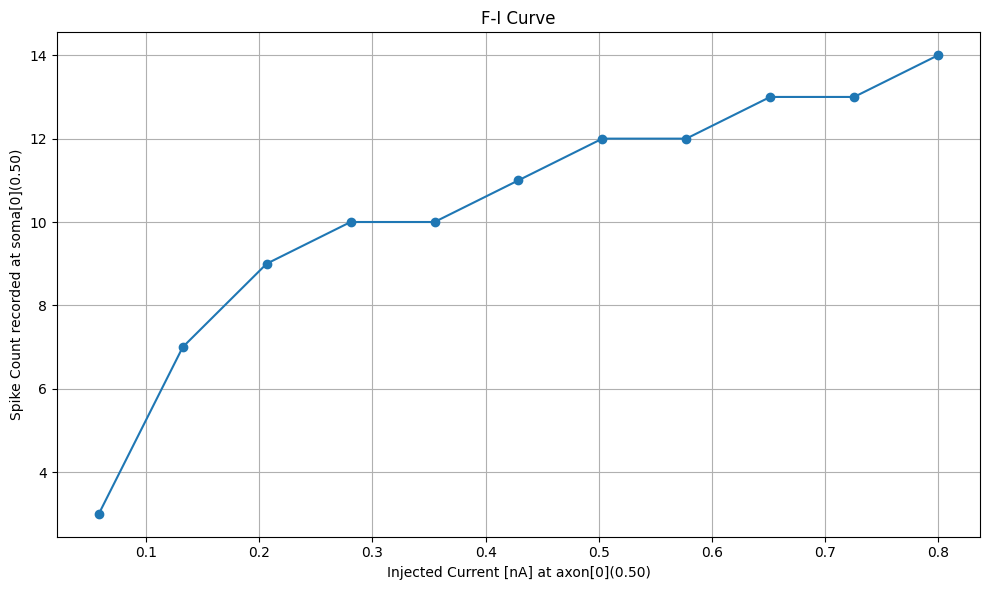

In [25]:
plot_iv_fi(injecting_section, injecting_segment, recording_section, recording_segment)

### Examining Local Dendritic Computations

Injecting and recording at different dendritic locations.
This setup isolates dendritic computations, showing how input at one dendrite 
propagates (or fails to propagate) to another part of the dendritic tree.

In [26]:
injecting_section = "dend[25]"
injecting_segment = 0.5
recording_section = "dend[50]"
recording_segment = 0.5

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


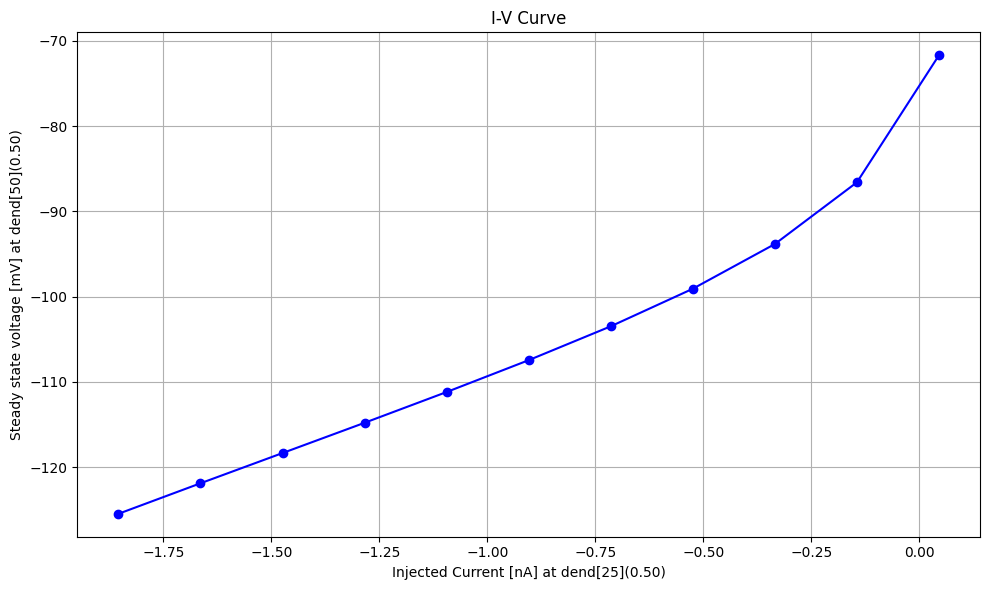

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


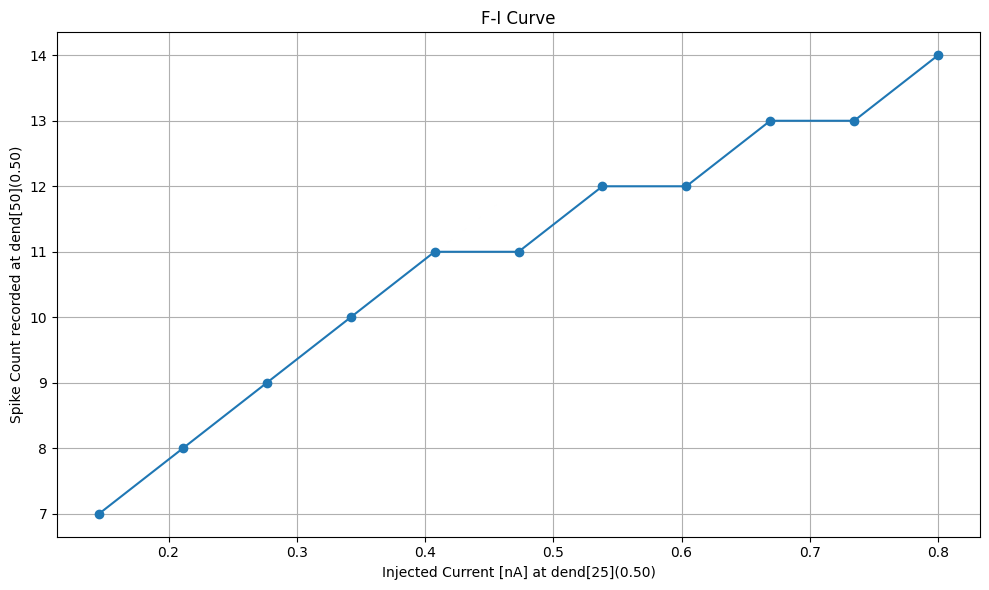

In [27]:
plot_iv_fi(injecting_section, injecting_segment, recording_section, recording_segment)

### Testing Whether Somatic Stimulation Reaches the Axon

Injecting current at the soma and recording at the axon.
This setup helps determine if somatic stimulation effectively depolarizes the axon 
enough to trigger an action potential.

In [28]:
injecting_section = "soma[0]"
injecting_segment = 0.5
recording_section = "axon[0]"
recording_segment = 0.5

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


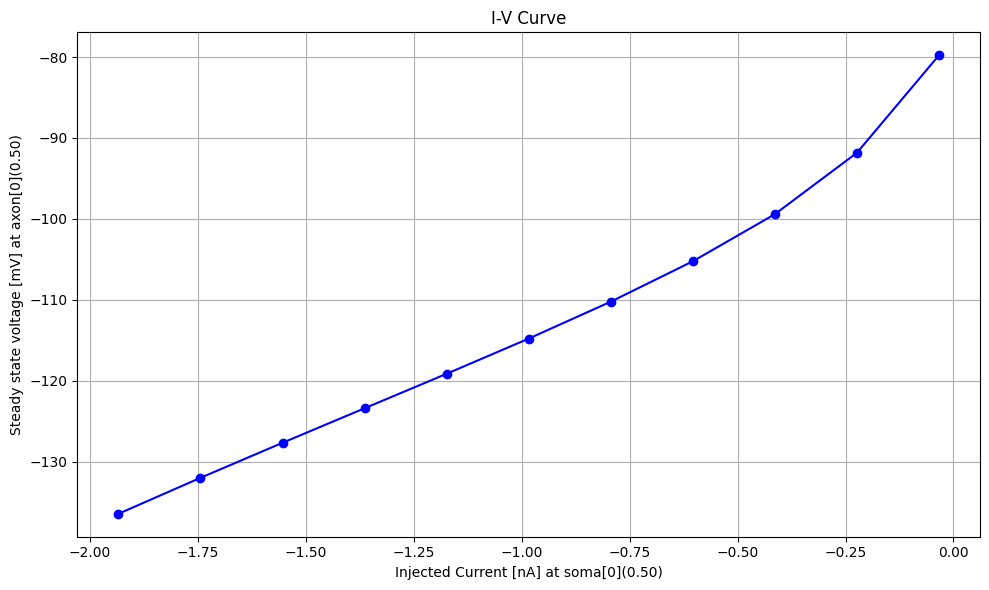

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


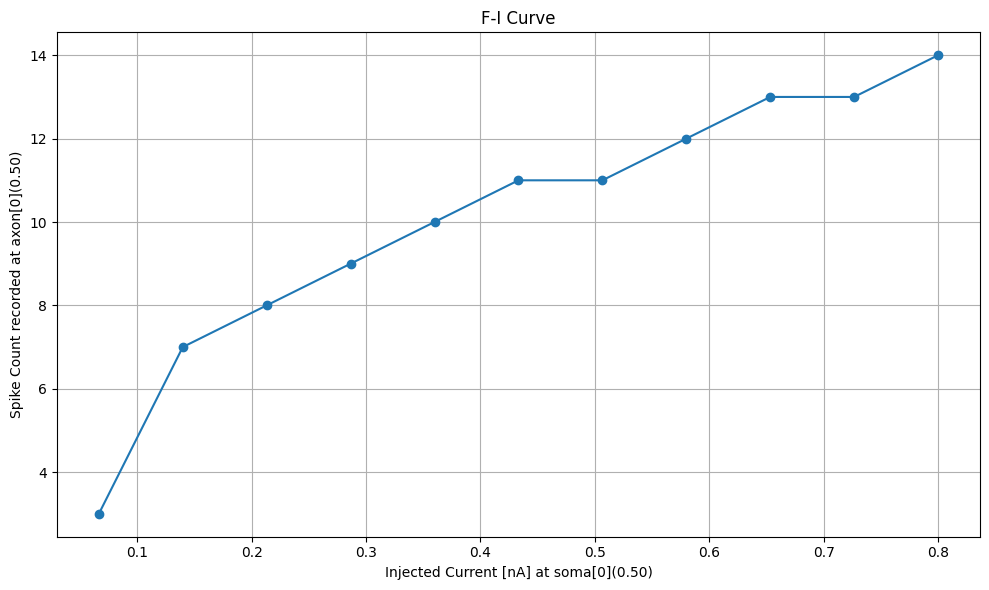

In [29]:
plot_iv_fi(injecting_section, injecting_segment, recording_section, recording_segment)